In [ ]:
try:
  # Use the %tensorflow_version magic if in colab.
  %tensorflow_version 2.x
except Exception:
  pass
  
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.layers import Dense, Conv2D, Dropout, BatchNormalization, Input, Activation, MaxPooling2D, Flatten
import os
import dlib
import cv2
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
import datetime
import plotly.express as px
from random import randint
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
%load_ext tensorboard

project_path = "drive/MyDrive/Colab Notebooks/GenderExtract"

In [ ]:
data = open(project_path+"/dataset/wiki_data.pickle", "rb")
data = pickle.load(data)

images = np.array(data['images'])
gender = np.array(data['gender'])
age = np.array(data['age'])
print('''The shape of the images array is : {}\n
The shape is an image is : {}\n
The shape of the gender array is : {}\n
The shape of the age array is : {}'''.format(images.shape, images[0].shape, gender.shape, age.shape))

In [ ]:
plt.figure()
i = 1

while(i <= 4):
    index = randint(0, len(images))
    img = images[index]
    
    plt.subplot(1, 4, i)
    plt.imshow(img)
    plt.title(gender[index][0])
    plt.title(age[index][0])
    i += 1

In [ ]:
gender_plotting = []

for i in gender:
    if i[0] == 1:
        gender_plotting.append('Male')
    else:
        gender_plotting.append('Female')

dataframe = pd.DataFrame({'gender' : gender_plotting})
fig = px.histogram(dataframe, x="gender")
fig.show()
del dataframe
del gender_plotting

In [ ]:
genderCategorical = []

for i in gender:
    if i[0] == 1:
        genderCategorical.append([1.0, 0.0])
    else:
        genderCategorical.append([0.0, 1.0])
genderCategorical = np.array(genderCategorical)

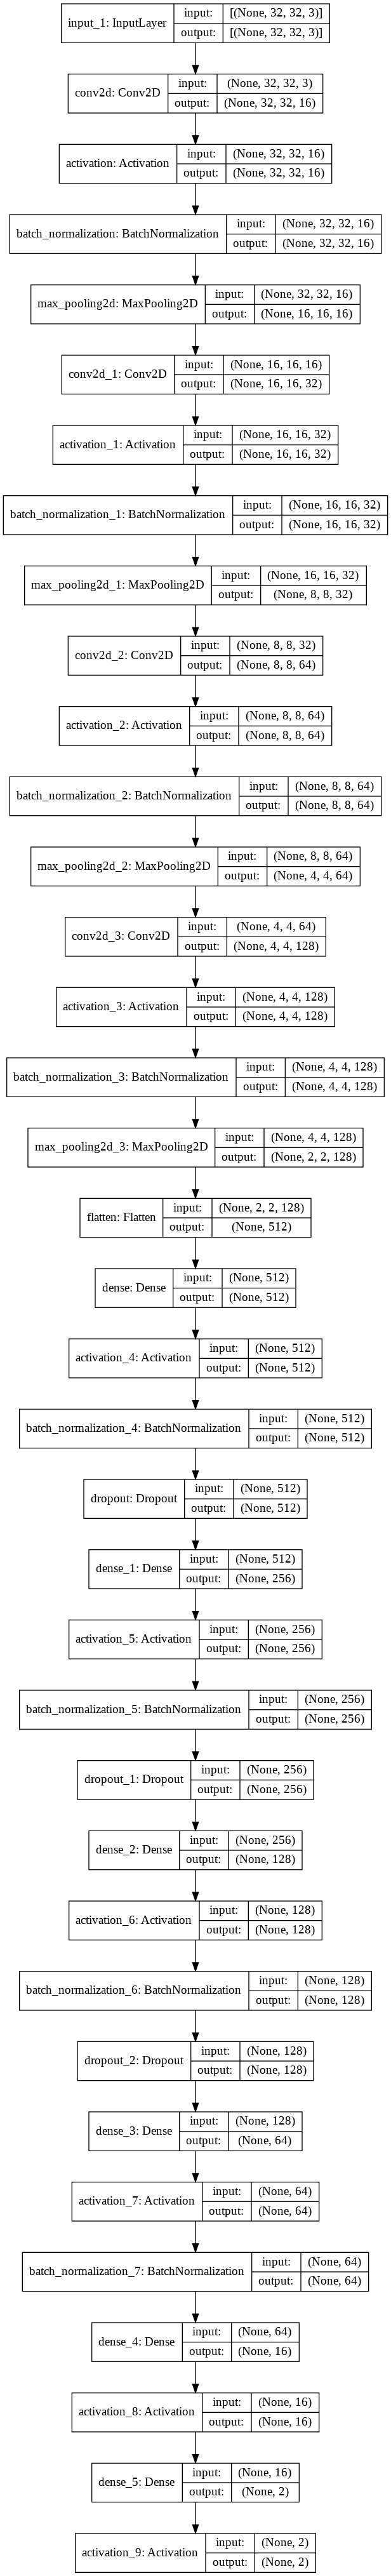

In [ ]:
layers = [Input(shape=(32,32,3))]
no_of_conv_layers = (16,32, 64,128)
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

for i in no_of_conv_layers:
    layers += [
            Conv2D(i, padding='same', kernel_size=(2,2)),
               Activation('relu'),
               BatchNormalization(),
               MaxPooling2D(pool_size=(2,2), strides=2, padding='same')
    ]

layers += [
           Flatten(),
           Dense(512),
           Activation('relu'),
           BatchNormalization(),
           Dropout(0.25),
           Dense(256),
           Activation('relu'),
           BatchNormalization(),
           Dropout(0.25),
           Dense(128),
           Activation('relu'),
           BatchNormalization(),
           Dropout(0.25),
           Dense(64),
           Activation('relu'),
           BatchNormalization(),
           Dense(16),
           Activation('relu'),
           Dense(2),
           Activation('softmax')
]
model = tf.keras.Sequential(layers)
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
log_dir = "drive/My Drive/Colab Notebooks/Tutorial/Gender Classifier/logs/" + datetime.datetime.now().strftime("%Y%m%D-%H%M%S")
# log_dir = "logs/"+ datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [TensorBoard(log_dir=log_dir), earlyStopping]
tf.keras.utils.plot_model(
    model, show_shapes=True)

In [ ]:
train_images, test_images, train_gender, test_gender = train_test_split(images, genderCategorical, 
                                                    test_size = .2, shuffle = True, random_state = 10)

num_train_examples = len(train_images) * 0.8
BATCH_SIZE = 64
model.fit(train_images, train_gender, epochs = 20, steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE),  
          batch_size = BATCH_SIZE, shuffle=True, validation_split = 0.2,
          callbacks = callbacks)

print("\nEvaluating the Model\n")
model.evaluate(test_images, test_gender, callbacks = callbacks)

In [ ]:
def take_photo( img_width = 48, img_height = 48, quality=0.8 ):
  js = Javascript('''
    async function takePhoto(img_width, img_height, quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await  navigator.mediaDevices.getUserMedia({video: {height:img_height, width:img_width}});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      ctx = canvas.getContext('2d')
      ctx.drawImage(video, 0, 0);
      imageData  = ctx.getImageData(1,1, Math.round(img_width), Math.round(img_height))
      stream.getVideoTracks()[0].stop();
      div.remove();
      return imageData.data
    }
    ''')
  display(js)
  data = eval_js('takePhoto({},{},{})'.format(img_width, img_height, quality))
  return data

In [ ]:
def rgba2rgb( rgba, background=(255,255,255) ):
    row, col, ch = rgba.shape

    if ch == 3:
        return rgba

    assert ch == 4, 'RGBA image has 4 channels.'

    rgb = np.zeros( (row, col, 3), dtype='float32' )
    r, g, b, a = rgba[:,:,0], rgba[:,:,1], rgba[:,:,2], rgba[:,:,3]

    a = np.asarray( a, dtype='float32' ) / 255.0

    R, G, B = background

    rgb[:,:,0] = r * a + (1.0 - a) * R
    rgb[:,:,1] = g * a + (1.0 - a) * G
    rgb[:,:,2] = b * a + (1.0 - a) * B

    return np.asarray( rgb, dtype='uint8' )

In [ ]:

img_height = 256
img_width = 256

try:
    data = take_photo(img_height, img_width, 0.3)
    img = []
    for i in sorted(data, key = lambda x : int(x)):
        img.append(data[i])
    img = np.reshape(img, (img_height, img_width,4))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

img = rgba2rgb(img)
plt.imshow(img)

In [ ]:
def extract_faces(img):
    cnn_face_detector = dlib.cnn_face_detection_model_v1(project_path+"/mmod_human_face_detector.dat")
    faces_cnn = cnn_face_detector(img, 1)
    faces = []
    if(len(faces_cnn) > 0):
        for face in faces_cnn:
            offset_x , offset_y  = max(face.rect.left(),0),max(face.rect.top(),0)
            target_width, target_height = face.rect.right() - offset_x, face.rect.bottom() - offset_y

            target_width = min(target_width, img.shape[1]-offset_x)
            target_height = min(target_height, img.shape[0]-offset_y)
            print("face", offset_x,offset_y,target_width,target_height)

            face_img = tf.image.crop_to_bounding_box(img, 
                                            offset_y, offset_x, 
                                            target_height,target_width)

            face_img = tf.image.resize(face_img, (32, 32), method=tf.image.ResizeMethod.BICUBIC, antialias=True)
            face_img = tf.dtypes.cast(face_img, tf.int32)
            faces.append({'face' : face_img.numpy(), 'coordinates' : [offset_x, offset_y, target_width, target_height]})
    return faces

def show_output(img, faces, predictions):
    for i, data in enumerate(faces):
        coordinates = data['coordinates']
        x1 = coordinates[0]
        y1 = coordinates[1]
        x2 = coordinates[2] + x1
        y2 = coordinates[3] + y1
        cv2.rectangle(img, (x1, y1), (x2, y2), (0,0,255), 1)
        gender = 'Male' if np.argmax(predictions[i]) == 0 else 'Female'
        cv2.putText(img, gender, (x1-3, y1), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,0,0), 1)
    plt.imshow(img)

In [ ]:
faces = extract_faces(img)
predict_X = []
for face in faces:
    predict_X.append(face['face'])

predict_X = np.array(predict_X)

predictions = []
if predict_X.shape[0] > 0 :
    predictions = model.predict(predict_X)

show_output(img, faces, predictions)

In [ ]:
%tensorboard --logdir "drive/My Drive/Colab Notebooks/Tutorial/Gender Classifier/logs/"